In [369]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,date, timedelta
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.pipeline import Pipeline

Load Data

In [297]:
data = pd.read_csv("Nat_Gas.csv")
data["Dates"] = pd.to_datetime(data["Dates"])
data.head()

/var/folders/bg/5dmr_ymn0g7d0fqz7043vr8c0000gp/T/ipykernel_71902/3248164292.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Dates"] = pd.to_datetime(data["Dates"])


,Dates,Prices
0,2020-10-31,10.1
1,2020-11-30,10.3
2,2020-12-31,11.0
3,2021-01-31,10.9
4,2021-02-28,10.9


Visualize

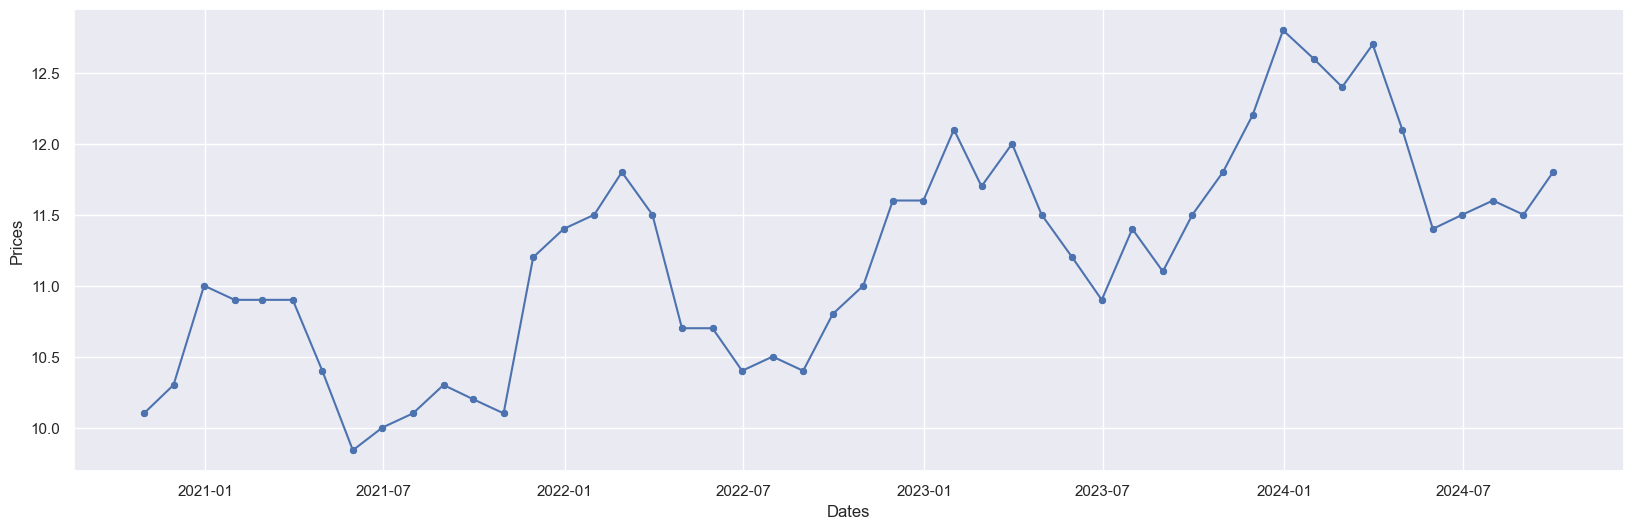

In [298]:
plt.figure(figsize= (20, 6))
sns.lineplot(x = data["Dates"], y = data["Prices"])
sns.scatterplot(x = data["Dates"], y = data["Prices"])
plt.show()

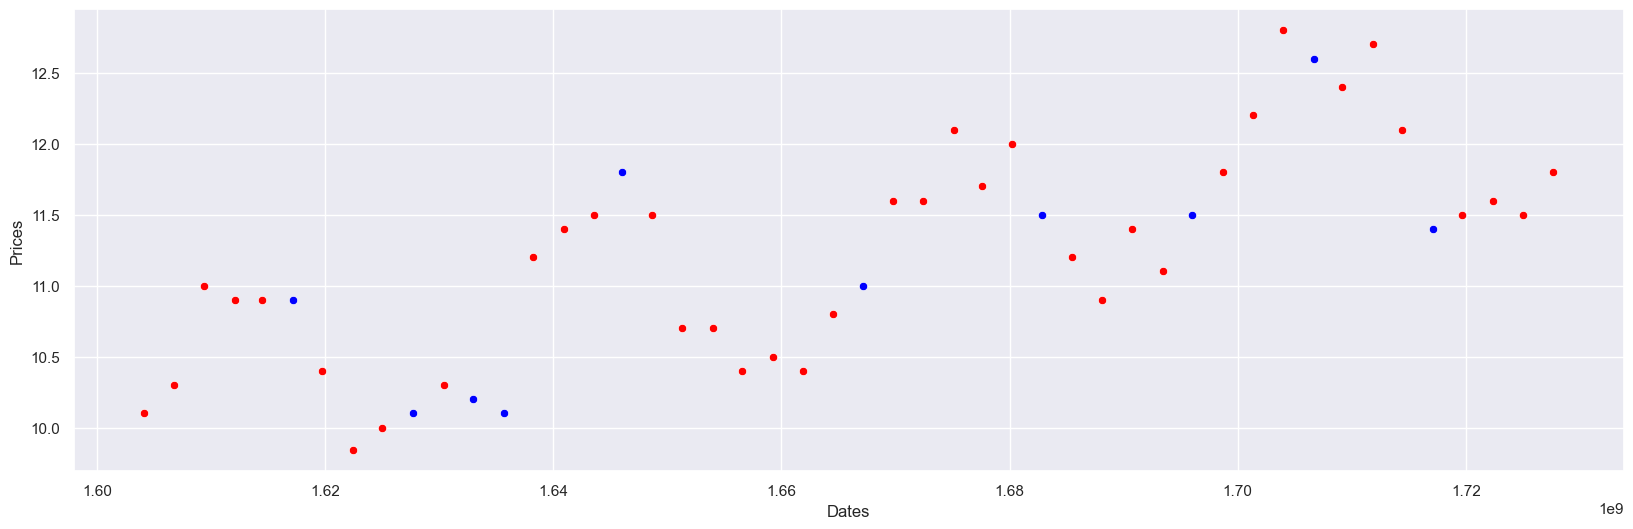

In [299]:
X_train, X_test, y_train, y_test = train_test_split(data["Dates"],data["Prices"], train_size= 0.8)
X_train, X_test = X_train.map(lambda x: x.timestamp()), X_test.map(lambda x: x.timestamp())
plt.figure(figsize= (20, 6))
sns.set_theme()
sns.scatterplot(x = X_train, y = y_train, color = "red")
sns.scatterplot(x = X_test, y = y_test, color = "blue")
plt.show()

Detrend

In [300]:
lr = LinearRegression()
lr.fit(pd.DataFrame(X_train), pd.DataFrame(y_train))
lr_line_train = lr.predict(pd.DataFrame(X_train)).flatten()
lr_line_test = lr.predict(pd.DataFrame(X_test)).flatten()

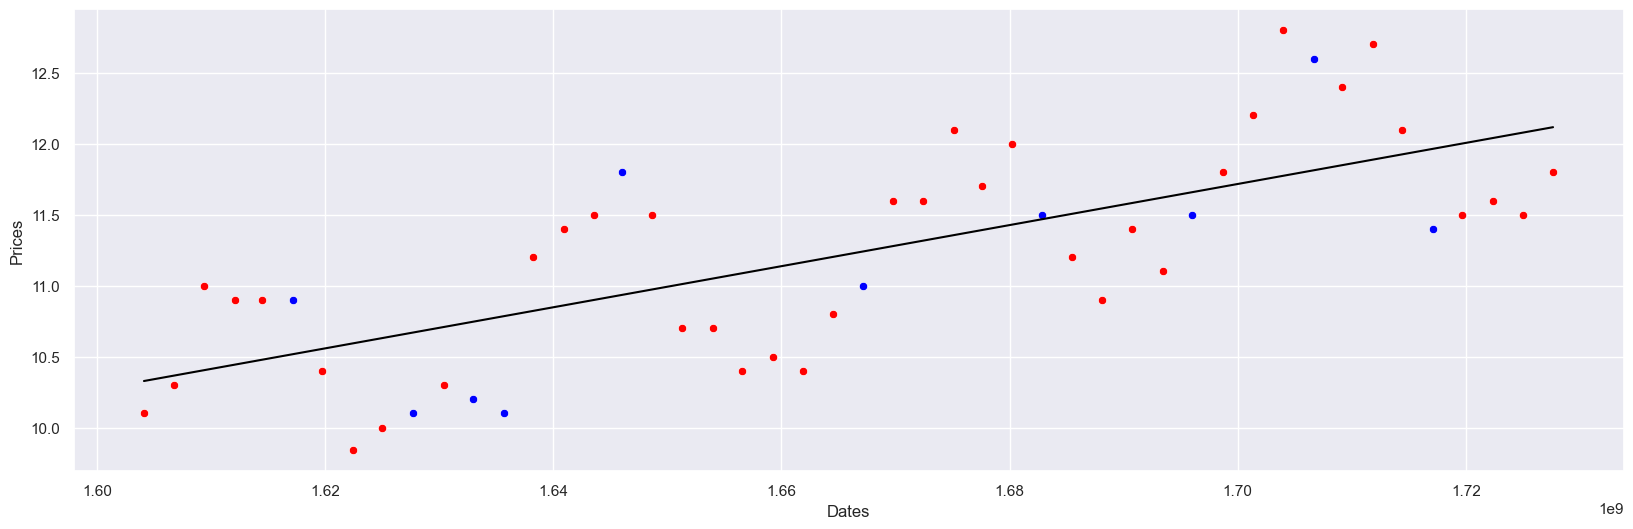

In [301]:
plt.figure(figsize= (20, 6))
sns.scatterplot(x = X_train, y = y_train, color = "red")
sns.lineplot(x = X_train, y = lr_line_train, color = "black")
sns.scatterplot(x = X_test, y = y_test, color = "blue")
plt.show()

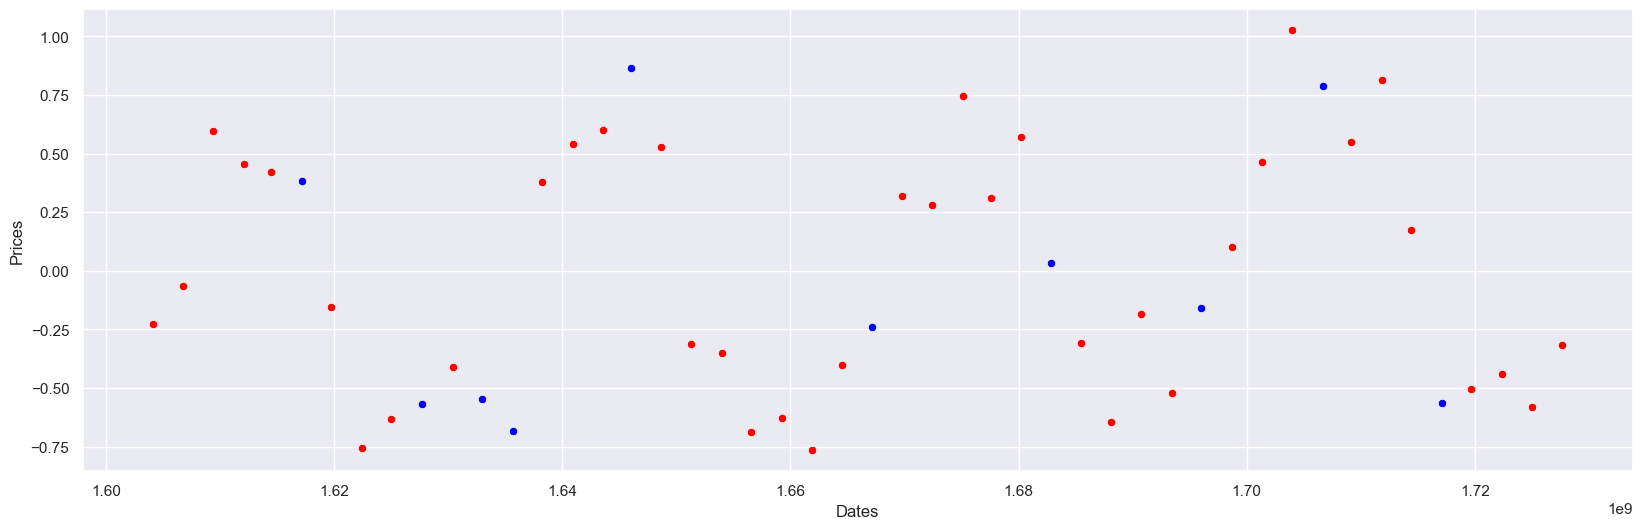

In [304]:
detrend_y_train = y_train - lr_line_train
detrend_y_test = y_test - lr_line_test
plt.figure(figsize= (20, 6))
sns.scatterplot(x = X_train, y = detrend_y_train, color = "red")
sns.scatterplot(x = X_test, y = detrend_y_test, color = "blue")
plt.show()

Deseason

In [305]:
rf = RandomForestRegressor()
rf.fit(pd.DataFrame(X_train), detrend_y_train)
rf_predict_train = rf.predict(pd.DataFrame(X_train))
rf_predict_test = rf.predict(pd.DataFrame(X_test))

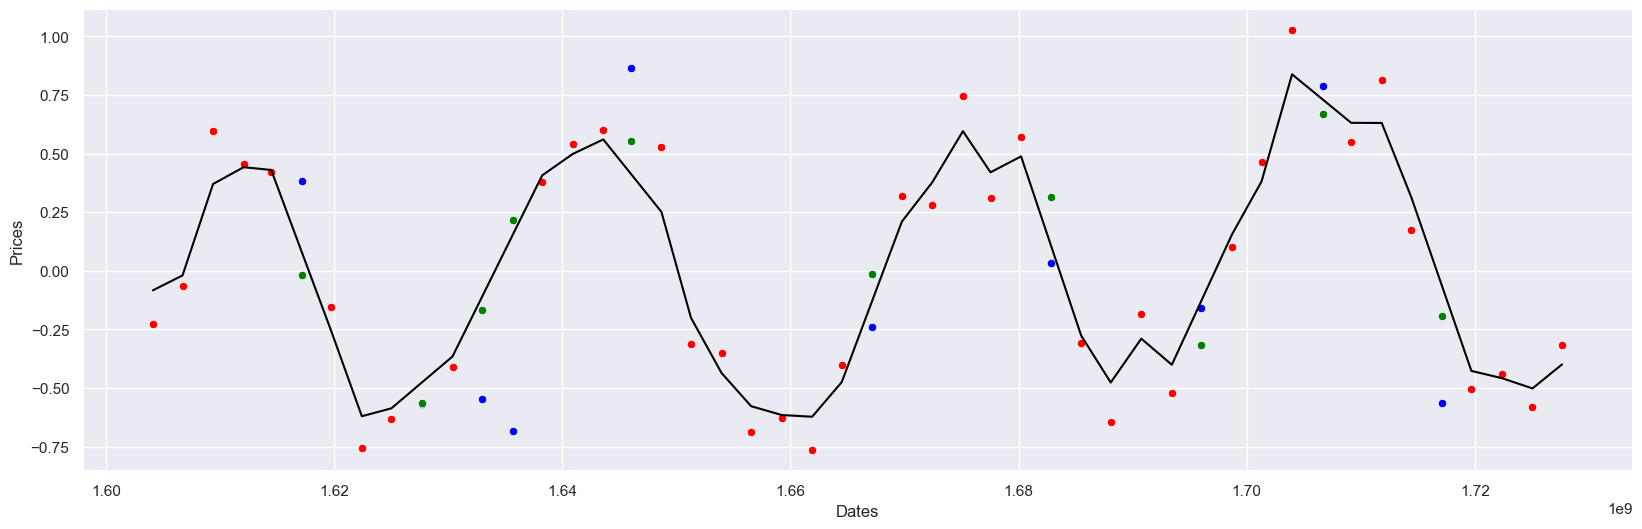

In [306]:
plt.figure(figsize= (20, 6))
sns.scatterplot(x = X_train, y = detrend_y_train, color = "red")
sns.lineplot(x = X_train, y = rf_predict_train, color = "black")
sns.scatterplot(x = X_test, y = detrend_y_test, color = "blue")
sns.scatterplot(x = X_test, y = rf_predict_test, color = "green")
plt.show()

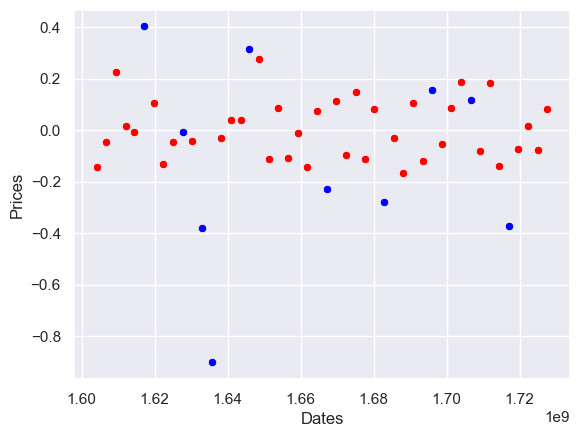

In [308]:
deseasoned_y_train = detrend_y_train - rf_predict_train
deseasoned_y_test = detrend_y_test - rf_predict_test
sns.scatterplot(x = X_train, y = deseasoned_y_train, color = "red")
sns.scatterplot(x = X_test, y = deseasoned_y_test, color = "blue")
plt.show()

PACF

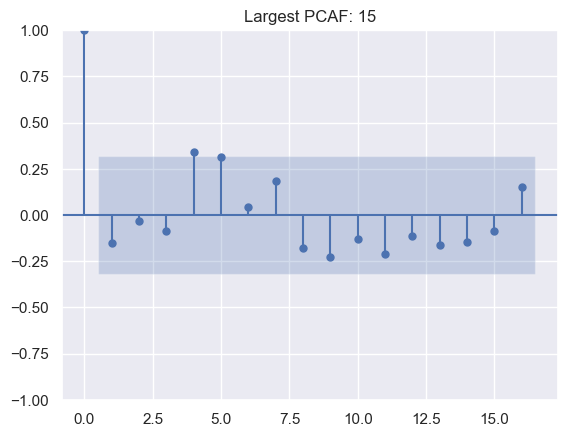

In [312]:
plot_pacf(deseasoned_y_train)
plt.title(f"Largest PCAF: {pacf(deseasoned_y_train)[1:].argmax()+1}")
plt.show()

Decycle

In [313]:
cyclic_df = pd.DataFrame({
    "time": X_train,
    "y_lag_8": deseasoned_y_train.shift(4),
    "y_lag_9": deseasoned_y_train.shift(5),
    "y": deseasoned_y_train
}).dropna()

In [314]:
X_cyclic_train, X_cyclic_test, y_cyclic_train, y_cyclic_test = train_test_split(
    cyclic_df[list(cyclic_df.columns[:-1])],
    cyclic_df[list(cyclic_df.columns[-1])],
    train_size=0.8,
    random_state=42)

In [315]:
rf_2 = RandomForestRegressor()
rf_2.fit(X_cyclic_train, y_cyclic_train)
rf2_cyclic_train = rf_2.predict(X_cyclic_train)
rf2_cyclic_test = rf_2.predict(X_cyclic_test)

/Users/aneyasobalkar/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


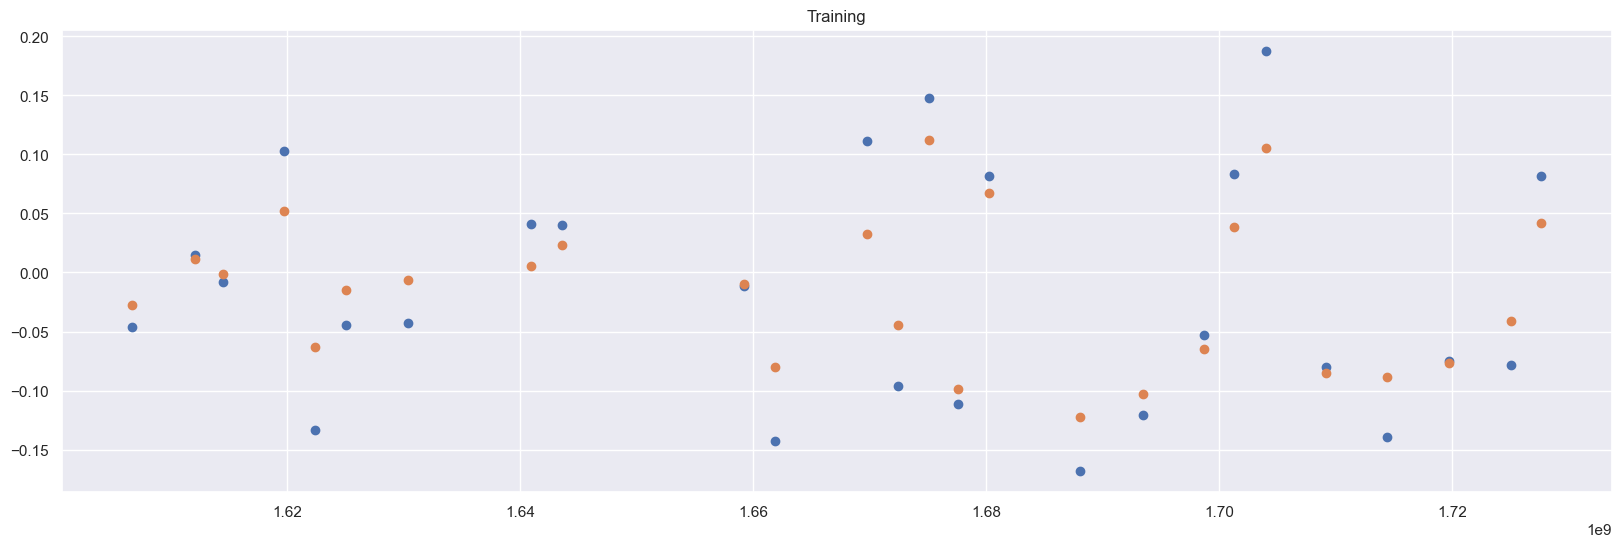

In [316]:
plt.figure(figsize=(20,6))
plt.scatter(X_cyclic_train[["time"]],y_cyclic_train)
plt.scatter(X_cyclic_train[["time"]],rf2_cyclic_train)
plt.title("Training")
plt.show()

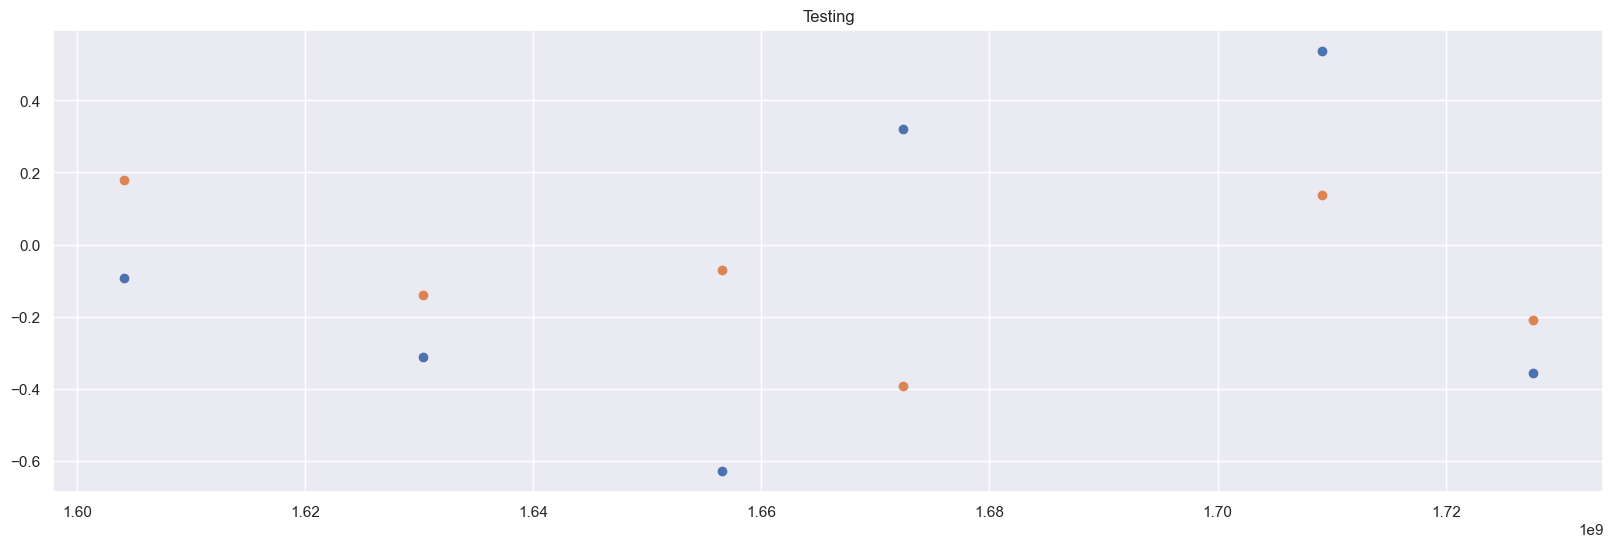

In [254]:
plt.figure(figsize=(20,6))
plt.scatter(X_cyclic_test[["time"]],y_cyclic_test)
plt.scatter(X_cyclic_test[["time"]],rf2_cyclic_test)
plt.title("Testing")
plt.show()

Assemeble

In [317]:
train_shift = deseasoned_y_train.shape[0]- rf2_cyclic_train.shape[0]
test_shift = deseasoned_y_test.shape[0] - rf2_cyclic_test.shape[0]

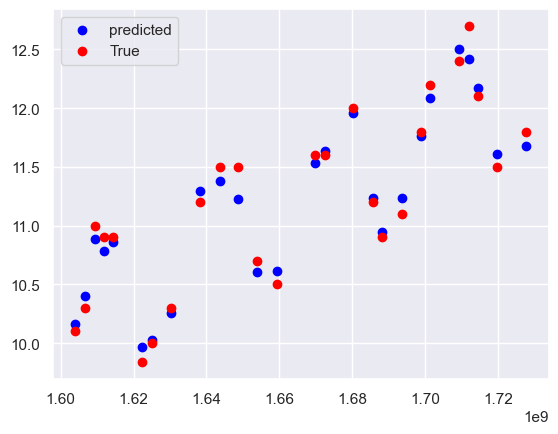

In [329]:
assembled_prediction_train = lr_line_train[train_shift:]+rf_predict_train[train_shift:] + rf2_cyclic_train
plt.scatter(X_train[train_shift:], assembled_prediction_train, color = "blue", label = "predicted")
plt.scatter(X_train[train_shift:],y_train[train_shift:], color = "red",label = "True")
plt.legend()
plt.show()

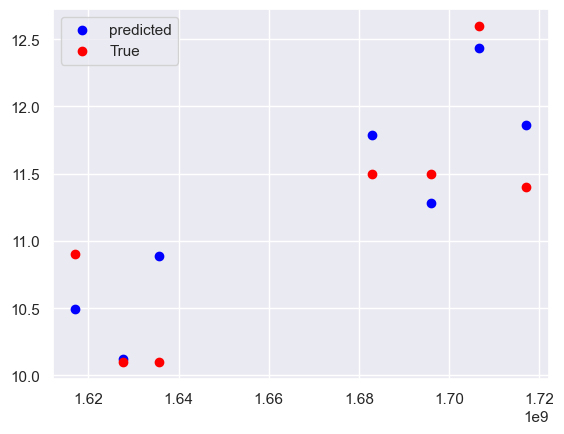

In [330]:
assembled_prediction_test = lr_line_test[test_shift:]+rf_predict_test[test_shift:] + rf2_cyclic_test
plt.scatter(X_test[test_shift:], assembled_prediction_test, color = "blue", label = "predicted")
plt.scatter(X_test[test_shift:],y_test[test_shift:], color = "red",label = "True")
plt.legend()
plt.show()

/Users/aneyasobalkar/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


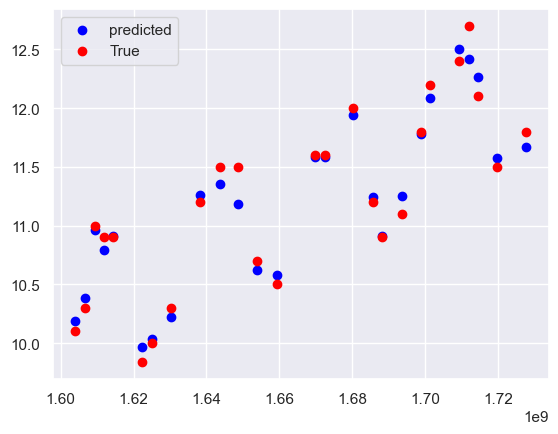

In [374]:
def pipeline(X_train, X_test, y_train, y_test):
    X_train, X_test = pd.DataFrame(X_train), pd.DataFrame(X_test)
    #Detrend the data
    lr = LinearRegression()
    lr.fit(pd.DataFrame(X_train), pd.DataFrame(y_train))
    lr_line_train = lr.predict(pd.DataFrame(X_train)).flatten()
    lr_line_test = lr.predict(pd.DataFrame(X_test)).flatten()
    detrend_y_train = y_train - lr_line_train
    detrend_y_test = y_test - lr_line_test
    #Deseason
    rf = RandomForestRegressor()
    rf.fit(pd.DataFrame(X_train), detrend_y_train)
    rf_predict_train = rf.predict(pd.DataFrame(X_train))
    rf_predict_test = rf.predict(pd.DataFrame(X_test))
    deseasoned_y_train = detrend_y_train - rf_predict_train
    deseasoned_y_test = detrend_y_test - rf_predict_test
    #Decycle
    cyclic_df = pd.DataFrame({
        "time": X_train.to_numpy().flatten(),
        "y_lag_8": deseasoned_y_train.shift(4),
        "y_lag_9": deseasoned_y_train.shift(5),
        "y": deseasoned_y_train
    }).dropna()
    #Decycle
    X_cyclic_train, X_cyclic_test, y_cyclic_train, y_cyclic_test = train_test_split(
        cyclic_df[list(cyclic_df.columns[:-1])],
        cyclic_df[list(cyclic_df.columns[-1])],
        train_size=0.8,
        random_state=42)
    rf_2 = RandomForestRegressor()
    rf_2.fit(X_cyclic_train, y_cyclic_train)
    rf2_cyclic_train = rf_2.predict(X_cyclic_train)
    rf2_cyclic_test = rf_2.predict(X_cyclic_test)
    train_shift = deseasoned_y_train.shape[0]- rf2_cyclic_train.shape[0]
    test_shift = deseasoned_y_test.shape[0] - rf2_cyclic_test.shape[0]
    #Assemble
    assembled_prediction_train = lr_line_train[train_shift:]+rf_predict_train[train_shift:] + rf2_cyclic_train
    assembled_prediction_test = lr_line_test[test_shift:]+rf_predict_test[test_shift:] + rf2_cyclic_test
    return train_shift, test_shift, assembled_prediction_train, assembled_prediction_test

train_shift, test_shift, assembled_prediction_train, assembled_prediction_test = pipeline(X_train, X_test, y_train, y_test)
plt.scatter(X_train[train_shift:], assembled_prediction_train, color = "blue", label = "predicted")
plt.scatter(X_train[train_shift:],y_train[train_shift:], color = "red",label = "True")
plt.legend()
plt.show()

In [375]:
#X_train[train_shift:].map(lambda x: datetime.fromtimestamp(x))
#X_train[test_shift:].map(lambda x: datetime.fromtimestamp(x))
prediction_dates = [date(2025, 5, 1) + timedelta(days=i) for i in range(15)]
prediction_dates

[datetime.date(2025, 5, 1),
 datetime.date(2025, 5, 2),
 datetime.date(2025, 5, 3),
 datetime.date(2025, 5, 4),
 datetime.date(2025, 5, 5),
 datetime.date(2025, 5, 6),
 datetime.date(2025, 5, 7),
 datetime.date(2025, 5, 8),
 datetime.date(2025, 5, 9),
 datetime.date(2025, 5, 10),
 datetime.date(2025, 5, 11),
 datetime.date(2025, 5, 12),
 datetime.date(2025, 5, 13),
 datetime.date(2025, 5, 14),
 datetime.date(2025, 5, 15)]